In [1]:
import numpy as np
import pandas as pd
import json
import os
from collections import Counter
from scipy.spatial import distance

from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, pairwise_distances
from sklearn.metrics import jaccard_similarity_score
from sklearn.cluster import KMeans, MiniBatchKMeans

from sqlalchemy_utils import database_exists, create_database
import psycopg2
from sqlalchemy import create_engine

%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [2]:
#places = ['socal', 'oc', 'newport', 'newportbeach', 'california', 'ca', 'irvine', 'tustin', 'orangecounty','missionviejo', 'costamesa', 'orange', 'huntingtonbeach']
places = ['sf', 'sanfrancisco','classpass', 'bayarea', 'california','missiondistrict']
others = ['bossbabe', 'fitfam', 'lululemon', 'bestgym', 'bestworkout', 'repost', 
          'photography', 'love', '2017', 'birthday', 'happybirthday', 'tbt','entrepreneur']
'''
         'yum', 'yummy', 'yay','women', 'womenempowerment','wisdom','wine', 'westcoast',
         'wednesday', 'weekend', 'weekendvibes','vsco', 'vscocam','video',
         'usa', 'vacation', 'valentinesday','tuesday', 'twinning', 'twins','truth',
         'today','thursday', 'tiu', 'tiubootycall', 'tiucheckin', 'tiuteam','sweatwithkayla',
         'thanksgiving', 'thankyou','texas','sundaymorning', 'sundayvibes', 'sunrise', 'sunset',
         'summertime', 'sun', 'sunday','style','staytuned','spring','soulcycle', 'socal', 'soma',
         'snapchat','siliconvalley', 'sisters','shop', 'shoplocal', 'shopping','sflife',
          'sfbayarea','september','selfie','sea', 'seattle','sanfransisco', 'sanjose', 'saturday', 
          'saturdaymorning', 'saturdays','sale', 'sand', 'sandiego', 'sanfran',
         'roadtrip','regram', 'regrann','red','quote', 'quoteoftheday', 'quotes', 'rainbow',
         'pink','photo', 'photooftheday', 'photoshoot','paloalto','painting','nyc', 'oakland', 'ocean',
         'norcal','nomakeup', 'newyear', 'newyork','mothersday','mondays','monday','mexico', 'miami',
         'memorialday', 'memorialdayweekend', 'memories', 'mermaid', 'merrychristmas','marin',
         'lululemonambassador', 'lunch','lovewins','loveislove','lol', 'lornajane', 'losangeles',
         'light', 'linkinbio','learn', 'learning','la', 'laborday', 'labordayweekend', 'latepost', 'latergram',
         'kids','kaylaitsines','internationalwomensday', 'instadaily', 'instafood', 'instagay', 'instagood',
          'instagram', 'instalike', 'instapic','igerssf','igdaily','houston','holiday', 'holidayparty', 
          'holidays', 'hollywood','hawaii', 'happyfriday', 'happyhalloween', 'happyholidays', 'happyhour',
          'happymonday', 'happynewyear', 'happysaturday', 'happysunday','halloween','green','grandopening',
         'gopro','goldengatebridge','girl', 'girlboss', 'girlpower', 'girls', 'fundraiser','gay',
          'follow', 'followme', 'food', 'foodie', 'foodporn','florida','festival',
          'fashion', 'fathersday','fall','fabletics','equinox','donate','dog','dogs','dinner','delicious',
          'design', 'datenight','dallas','congratulations','coffee', 'colorado', 'comingsoon','classpasssf',
          'charity', 'cheers', 'chicago', 'chocolate', 'christmas','ca', 'cali','brooklyn', 'brunch',
          'breakfast','boomerang','blog', 'blogger','bike', 'birthdaygirl', 'blackandwhite','bff',
          'beyonce','baseball','backtoschool','atlanta', 'avocado', 'alwayslearning','anniversary',
          '4thofjuly', '2016']
'''



"\n         'yum', 'yummy', 'yay','women', 'womenempowerment','wisdom','wine', 'westcoast',\n         'wednesday', 'weekend', 'weekendvibes','vsco', 'vscocam','video',\n         'usa', 'vacation', 'valentinesday','tuesday', 'twinning', 'twins','truth',\n         'today','thursday', 'tiu', 'tiubootycall', 'tiucheckin', 'tiuteam','sweatwithkayla',\n         'thanksgiving', 'thankyou','texas','sundaymorning', 'sundayvibes', 'sunrise', 'sunset',\n         'summertime', 'sun', 'sunday','style','staytuned','spring','soulcycle', 'socal', 'soma',\n         'snapchat','siliconvalley', 'sisters','shop', 'shoplocal', 'shopping','sflife',\n          'sfbayarea','september','selfie','sea', 'seattle','sanfransisco', 'sanjose', 'saturday', \n          'saturdaymorning', 'saturdays','sale', 'sand', 'sandiego', 'sanfran',\n         'roadtrip','regram', 'regrann','red','quote', 'quoteoftheday', 'quotes', 'rainbow',\n         'pink','photo', 'photooftheday', 'photoshoot','paloalto','painting','nyc', 'oak

In [3]:
def CollectTags(f, inputDir):
    try:
        json_data = open(inputDir+"/"+f.lower()+"/"+f.lower()+".json")
    except:
        print ("fail", f)
        return ""
    j = json.load(json_data)
    json_data.close()
    totalTags = ""
    for i in range(len(j)):
        if 'tags' in j[i].keys():
            try:
                listostring=[]
                for b in j[i]['tags']:
                    if (b.lower() in places or b.lower() in others or b == f): continue
                    else: listostring.append(b)
                string = " " + " ".join(listostring)
                totalTags += string
            except:
                print("other",f)
                pass
    return totalTags
        


In [4]:
studioSF = pd.read_pickle("NewFrame_SF")
studioOC = pd.read_pickle("NewFrame_OC")

In [5]:
studioNames_SF = studioSF.columns.get_values().tolist()
newrow = [a[0] for a in studioSF.loc[1,:].tolist()]
studioSF.loc[1,:]=newrow
studioSF = studioSF.rename(columns=studioSF.iloc[1])
studioSF.loc[1,:]=studioNames_SF
studioSF.head()

,17thstreetathleticclubsf,24hourfitness,my3fit,thirdstreetboxing,abmixedmartialarts,advanceyourself,aerialartique,alkalignme,linesballet,teamaka,...,bodyfi,fitlocalfit,movesf,yogabeachsf,core40,blakefit,xtrimbollywood,SVMAA,hgxfit,koafitness
0,"[[Gyms, Cycling Classes, Bikes]]","[[Gyms, Trainers]]","[[Trainers, Cardio Classes, Nutritionists]]","[[Gyms, Trainers, Boxing]]",[[Martial Arts]],"[[Gyms, Trainers, Boot Camps]]",[[Dance Studios]],[[Gyms]],"[[Performing Arts, Dance Schools]]",[[Martial Arts]],...,"[[Pilates, Boot Camps, Trainers]]","[[Trainers, Gyms, Yoga]]","[[Gyms, Trainers]]","[[Yoga, Pilates, Cardio Classes]]","[[Pilates, Cycling Classes, Trainers]]",[[Trainers]],[[Dance Studio]],[[Marital Arts]],[[Interval Training Gyms]],"[[Martial Arts, Boxing, Gyms]]"
1,17th Street Athletic Club,24 Hour Fitness - Redwood Cit,3FIT,3rd Street Boxing Gym,AB Mixed Martial Arts Academy,Advanced Sports Performance,Aerial Artique,Alkalign Studios,Alonzo King LINES Dance Center,American Kickboxing Academy,...,bodyFi,fit GLEN fit,move-sf,yogabeach,CORE40 SoMa,BlakeFIT,Fusion Beatz,Sunnyvale Martial Arts Academy,Homegrown Crossfit,KOA Fitness Mountain View
2,19,144,57,103,57,42,32,19,115,34,...,143,28,45,20,84,32,16,29,29,55
3,5.0,3.0,5.0,5.0,5.0,5.0,4.5,4.5,4.5,4.5,...,4.5,4.5,5.0,4.5,4.5,5,5,4.5,5,5
4,94110,94063,95051,94107,94134,94070,94103,94022,94103,94087,...,94111,94131,94115,94122,94103,94114,94062,94087,94070,94043


In [6]:
studioNames_OC = studioOC.columns.get_values().tolist()
newrow = [a for a in studioOC.loc[1,:].tolist()]
studioOC.loc[1,:]=newrow
studioOC = studioOC.rename(columns=studioOC.iloc[1])
studioOC.loc[1,:]=studioNames_OC
studioOC.head()

,3dfitnessgymoc,9round,alkalignme,bakerranchyoga,barrysbootcamp,bethechangeyoga,bike2thebeattustin,bikramyogairvine,ckonorthtustin,caffeyoga,...,barmethod,thehauteroom,totalmmastudios,triadyogaandpilates,trimfitnessstudio,unionryde,vibeshotyoga,wildsideyoga,yogashaktistudio,ilovekickboxing
0,"[[Trainers, Gyms]]","[[Boxing, Trainers]]",[[Barre Classes]],[[Yoga]],"[[Trainers, Gyms, Boot Camps]]",[[Yoga]],[[Cycling Classes]],[[Yoga]],[[Kickboxing]],"[[Reiki, Yoga, Pilates]]",...,[[Barre Classes]],"[[Trainers, Gyms, Pilates]]",[[Martial Arts]],"[[Yoga, Pilates]]","[[Trainers, Gyms, Pilates]]",[[Cycling Classes]],"[[Yoga, Barre Classes, Pilates]]",[[Yoga]],"[[Yoga, Meditation Centers]]","[[Gyms, Kickboxing]]"
1,3D Fitness,9Round,Alkalign Studios,Baker Ranch Yoga,Barry's Bootcamp Irvine,Be The Change Yoga - Orange County,Bike2thebeat,Bikram Yoga Irvine,CKO Kickboxing,Caffe Yoga,...,The Bar Method,The Haute Room,Total MMA Studios,Triad Yoga & Pilates,Trim Fitness Studio,UNION Ryde,Vibes Hot Yoga,WildSide Yoga,Yoga Shakti Wellness Center,iLoveKickboxing.com
2,40,58,17,26,65,55,68,176,35,69,...,27,65,62,108,80,297,30,45,98,29
3,5.0,5.0,5.0,5.0,4.5,5.0,5.0,4.5,5.0,5.0,...,5.0,5.0,4.5,5.0,5.0,5.0,5.0,5.0,4.5,5.0
4,92602,92626,92620,92630,92612,92602,92782,92620,92653,92782,...,92780,92782,92780,92660,92630,92660,92663,92708,92612,92708


In [7]:
#studioDF.iloc[studioDF.columns.get_loc('soulcycle'), 0] = [['Cycling Classes']]
#studioDF.head()

In [8]:
inputDir_SF = "SiliconValley"
inputDir_OC = "SampleSet"

In [9]:
studioSF.rename(columns={'bodytemptyoga': 'bodytempyoga'}, inplace=True)
#studioSF.rename(columns={'corestudiospx': 'corestudiopx'}, inplace=True)
studioSF.rename(columns={'eskabodaansep': 'eskabodaan'}, inplace=True)
studioSF.rename(columns={'rougeandsaintfitness':'rogueandsaintfitness'}, inplace=True)
#studioSF.rename(columns={'thedaileymethod':'thedailymethod'}, inplace=True)
studioSF.rename(columns={'B3strong':'b3strong'}, inplace=True)
studioSF.rename(columns={'SVMAA':'svmaa'}, inplace=True)

In [10]:
titles_SF = studioSF.columns.get_values().tolist()# if a in os.listdir(inputDir)]

studioNames_SF = [a for a in studioSF.loc[1,:].values.tolist()]
genres_SF = [a for a in studioSF.loc[0,:].values.tolist()]
hashtags_SF = [CollectTags(f, inputDir_SF) for f in titles_SF]
ranks_SF = [i for i in range(len(hashtags_SF))]
reviews_SF = [a for a in studioSF.loc[2,:].values.tolist()]
stars_SF = [a for a in studioSF.loc[3,:].values.tolist()]
zip_SF = [a for a in studioSF.loc[4,:].values.tolist()]
print(len(titles_SF), len(genres_SF), len(studioNames_SF), len(hashtags_SF))

151 151 151 151


In [11]:
titles_OC = studioOC.columns.get_values().tolist()# if a in os.listdir(inputDir)]

studioNames_OC = [a for a in studioOC.loc[1,:].values.tolist()]
genres_OC = [a for a in studioOC.loc[0,:].values.tolist()]
hashtags_OC = [CollectTags(f, inputDir_OC) for f in titles_OC]
ranks_OC = [i+len(ranks_SF) for i in range(len(hashtags_OC))]
reviews_OC = [a for a in studioOC.loc[2,:].values.tolist()]
stars_OC = [a for a in studioOC.loc[3,:].values.tolist()]
zip_OC = [a for a in studioOC.loc[4,:].values.tolist()]
print(len(titles_OC), len(genres_OC), len(studioNames_OC), len(hashtags_OC))
print(ranks_OC[-1])

54 54 54 54
204


In [12]:
savedFrame_SF = pd.DataFrame({'name': titles_SF, 'studioName': studioNames_SF, 'type': genres_SF, 'hashtags': hashtags_SF, 'rank': ranks_SF, 'review': reviews_SF, 'star': stars_SF, 'zip': zip_SF})
savedFrame_OC = pd.DataFrame({'name': titles_OC, 'studioName': studioNames_OC, 'type': genres_OC, 'hashtags': hashtags_OC, 'rank': ranks_OC, 'review': reviews_OC, 'star': stars_OC, 'zip': zip_OC})

dbname_sf = 'studio_db_SF'
dbname_oc = 'studio_db_OC'
username = 'MeghanFrate'
pswd = 'pizza'

engine = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname_sf))

if not database_exists(engine.url):
    create_database(engine.url)

savedFrame_SF.to_sql('studios_SF', engine, if_exists="replace")


engine2 = create_engine('postgresql://%s:%s@localhost/%s'%(username,pswd,dbname_oc))

if not database_exists(engine2.url):
    create_database(engine2.url)
    
savedFrame_OC.to_sql('studios_OC', engine2, if_exists="replace")

con = None
con = psycopg2.connect(database = dbname_SF, user = username, host='localhost', password=pswd)

# query:
sql_query = """
SELECT * FROM studios;
"""
data_from_sql_sf = pd.read_sql_query(sql_query,con)

data_from_sql_sf.head()

con = None
con = psycopg2.connect(database = dbname_OC, user = username, host='localhost', password=pswd)

# query:
sql_query = """
SELECT * FROM studios;
"""
data_from_sql_oc = pd.read_sql_query(sql_query,con)

data_from_sql_oc.head()

In [13]:
data_from_sql_sf = savedFrame_SF
data_from_sql_oc = savedFrame_OC
totDF = pd.concat([savedFrame_SF, savedFrame_OC])
#print(len(totDF.index.tolist()), len(savedFrame_SF.index.tolist()),len(savedFrame_OC.index.tolist()))
#print(len(hashtags_OC), len(hashtags_SF))
totDF.head()

205 151 54
54 151


,hashtags,name,rank,review,star,studioName,type,zip
0,17thstreetfitnesschallenge indoorcycling wekn...,17thstreetathleticclubsf,0,19,5.0,17th Street Athletic Club,"[[Gyms, Cycling Classes, Bikes]]",94110
1,funning lafitness equinox planetfitness cali...,24hourfitness,1,144,3.0,24 Hour Fitness - Redwood Cit,"[[Gyms, Trainers]]",94063
2,stickmobility strongcore exercise body...,my3fit,2,57,5.0,3FIT,"[[Trainers, Cardio Classes, Nutritionists]]",95051
3,davesclass daveisamazing boxingmyfirstlove g...,thirdstreetboxing,3,103,5.0,3rd Street Boxing Gym,"[[Gyms, Trainers, Boxing]]",94107
4,mma abmma muaythai bjj brazilianjiujitsu qu...,abmixedmartialarts,4,57,5.0,AB Mixed Martial Arts Academy,[[Martial Arts]],94134


In [14]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=200000, min_df=0.1, ngram_range=(1,1))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(hashtags_SF+hashtags_OC)

CPU times: user 1.59 s, sys: 59.6 ms, total: 1.64 s
Wall time: 1.75 s


In [15]:
terms = tfidf_vectorizer.get_feature_names()
print(len(terms))

1068


In [16]:
dist = 1 - cosine_similarity(tfidf_matrix)

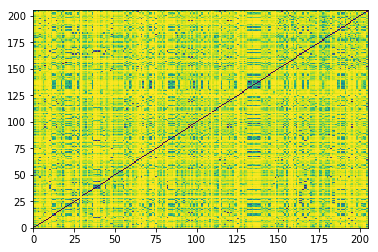

In [17]:
plt.pcolor(dist)

In [18]:
def similarities(M, studio):
    ind = titles.index(studio)
    sims = M[ind][:]
    ordered = [(isim, sim) for isim, sim in enumerate(sims)]
    sortd = sorted(ordered, key=lambda tup: tup[1])
    return sortd

dense = tfidf_matrix.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=terms, index=titles)
#print(df.head(10))
#print(df.loc['barmethod'])
for x in df.index.values.tolist():
    p = df.loc[x].sort_values() #sort_values(ascending=False)[:20]
    try:
        #(s[s > 0].sort_values(ascending=False)[:20]).plot(kind='bar', title=x)
        p.plot(kind='bar', title=x)
    except:
        print(x)

dense = tfidf_matrix.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=terms, index=titles)
#print(df.head(10))
s = pd.Series(df.loc['unionryde'])
s[s > 0].sort_values(ascending=False)[:10]

dense = tfidf_matrix.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=terms, index=titles)
#print(df.head(10))
s = pd.Series(df.loc['carrillomuaythai'])
s[s > 0].sort_values(ascending=False)[:10]

In [19]:
num_clusters = 9 #

km = KMeans(n_clusters=num_clusters, n_init=100)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()


CPU times: user 2min 11s, sys: 8.12 s, total: 2min 19s
Wall time: 42.3 s


In [33]:
#studios = { 'title': titles, 'rank': ranks, 'hashtags': hashtags, 'cluster': clusters, 'genre': genres }

#frame = pd.DataFrame(studios, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])
#frame.head(10)

data_from_sql['clusters'] = clusters
clusternum = (data_from_sql.loc[data_from_sql['name'] == 'linesballet'])['clusters'].iloc[0]
print((data_from_sql.loc[29])['clusters'])

aa = similarities(dist, "mixxyoga")

print (titles[aa[1][0]])
for bi, b in enumerate(aa):
    if data_from_sql.loc[b[0]]['clusters'] == clusternum:
        continue
    secondsimilar = b[0]
    break
    

print (aa)
print (titles[secondsimilar])

aa = sorted(similarities(dist, "mixxyoga"), key=lambda tup: tup[0])
bb = sorted(similarities(dist, "12life"), key=lambda tup: tup[0])
#print(aa)
#print("")
#print(bb)
#print("")
gg=[(aa[i][0], np.sqrt((aa[i][1])**2+(bb[i][1])**2)) for i in range(len(bb))]
ll = sorted(gg, key=lambda tup: tup[1])
#print(ll)
print(titles[ll[2][0]])
print(titles[13])

In [20]:
print(len(clusters))
print(len(hashtags_OC+hashtags_SF))
print(len(totDF.index.tolist()))

205
205
205


In [21]:
totDF['clusters'] = clusters
#newDF = totDF.assign(clusters = clusters)
totDF['clusters'].value_counts()

6    47
0    39
1    32
2    18
3    17
5    14
8    13
4    13
7    12
Name: clusters, dtype: int64

In [23]:
from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

cluster_names = {}
cluster_genres = {}
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    cluster_names[i]=""
    cluster_genres[i]=[]
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        cluster_names[i] += terms[ind].split(' ')[0] + " "
        print(' %s' % terms[ind].split(' ')[0], end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in totDF.loc[i]['studioName'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d group:" % i, end='')
    for g in totDF.loc[i]['type'].values.tolist():
        cluster_genres[i] += g
        print(' %s,' % g, end='')
    print() #add whitespace
    print() #add whitespace
    
print()

Top terms per cluster:

Cluster 0 words: yoga, yogaeverydamnday, namaste, yogalove, yogi, meditation,

Cluster 0 titles: 17th Street Athletic Club, 3D Fitness,

Cluster 0 group: [['Gyms', 'Cycling Classes', 'Bikes']], [['Trainers', 'Gyms']],

Cluster 1 words: fitness, workout, gym, fit, personaltrainer, motivation,

Cluster 1 titles: 24 Hour Fitness - Redwood Cit, 9Round,

Cluster 1 group: [['Gyms', 'Trainers']], [['Boxing', 'Trainers']],

Cluster 2 words: sfyoga, yoga, yogaeverydamnday, yogasf, yogalove, vinyasa,

Cluster 2 titles: 3FIT, Alkalign Studios,

Cluster 2 group: [['Trainers', 'Cardio Classes', 'Nutritionists']], [['Barre Classes']],

Cluster 3 words: pilates, fitness, pilatesreformer, pilatesinstructor, workout, reformer,

Cluster 3 titles: 3rd Street Boxing Gym, Baker Ranch Yoga,

Cluster 3 group: [['Gyms', 'Trainers', 'Boxing']], [['Yoga']],

Cluster 4 words: kickboxing, boxing, martialarts, fitness, workout, mma,

Cluster 4 titles: AB Mixed Martial Arts Academy, Barry's 

In [91]:
#print(cluster_genres)

In [24]:
cluster_category = {}
for i in range(num_clusters):
    wordCount = Counter([x for sublist in cluster_genres[i] for x in sublist])
    print(dict(wordCount))
    cluster_category[i]=wordCount.most_common(1)[0][0]
print (cluster_category)

{'Gyms': 2, 'Cycling Classes': 1, 'Bikes': 1, 'Trainers': 1}
{'Gyms': 1, 'Trainers': 2, 'Boxing': 1}
{'Trainers': 1, 'Cardio Classes': 1, 'Nutritionists': 1, 'Barre Classes': 1}
{'Gyms': 1, 'Trainers': 1, 'Boxing': 1, 'Yoga': 1}
{'Martial Arts': 1, 'Trainers': 1, 'Gyms': 1, 'Boot Camps': 1}
{'Gyms': 1, 'Trainers': 1, 'Boot Camps': 1, 'Yoga': 1}
{'Dance Studios': 1, 'Cycling Classes': 1}
{'Gyms': 1, 'Yoga': 1}
{'Performing Arts': 1, 'Dance Schools': 1, 'Kickboxing': 1}
{0: 'Gyms', 1: 'Trainers', 2: 'Trainers', 3: 'Gyms', 4: 'Martial Arts', 5: 'Gyms', 6: 'Dance Studios', 7: 'Gyms', 8: 'Performing Arts'}


In [62]:
'''
def precision(clusterWord, keywordGroups):
    TP = 0
    FP = 0
    for i in keywordGroups:
        if clusterWord in i: TP+=1
        else: FP+=1
    prec = float(TP)/(float(TP)+float(FP))
    return prec

def recall(clusterWord, keywordGroups, keywordNonCluster):
    TP = 0
    FN = 0
    for i in keywordGroups:
        if clusterWord in i: TP+=1
    for i in keywordNonCluster:
        if clusterWord in [x for sublist in i for x in sublist]: FN+=1
    rec = float(TP)/(float(TP)+float(FN))
    return rec
'''
def TP_FP(clusterWord, keywordGroups):
    TP = 0
    FP = 0
    for i in keywordGroups:
        if clusterWord in i: TP+=1
        else: FP+=1
    return TP, FP

def FN(clusterWord, keywordGroups, keywordNonCluster):
    TP = 0
    FN = 0
    for i in keywordNonCluster:
        if clusterWord in [x for sublist in i for x in sublist]: FN+=1
    return FN

def F1(TP, FP, FN):
    P = float(TP)/(float(TP)+float(FP))
    R = float(TP)/(float(TP)+float(FN))
    return 2.*P*R/(R+P)


In [93]:
totTp, totFp, totFn = 0, 0, 0
for cluster in range(num_clusters):
    clusterWord = cluster_category[cluster]
    #P = precision(clusterWord, cluster_genres[cluster])
    otherLists = [cluster_genres[i] for i in range(num_clusters) if i != cluster]
    #R = recall(clusterWord, cluster_genres[cluster], otherLists)
    Tp, Fp = TP_FP(clusterWord, cluster_genres[cluster])
    totTp+=Tp
    totFp+=Fp
    Fn = FN(clusterWord, cluster_genres[cluster], otherLists)
    totFn+=Fn
    #print (P, R)
print(F1(totTp, totFp, totFn))

0.7156549520766772


##0.1,7
0.9166666666666666 0.7333333333333333
0.975609756097561 0.9090909090909091
0.5 0.875
0.7777777777777778 0.7
0.46153846153846156 0.6
0.5517241379310345 0.8421052631578947
0.8571428571428571 0.6

##0.1,9
0.7701863354037267
0.7692307692307693 0.7692307692307693
1.0 0.7142857142857143
0.45454545454545453 0.45454545454545453
0.8 0.7272727272727273
0.9642857142857143 0.8181818181818182
0.7692307692307693 0.7692307692307693
0.9166666666666666 0.6111111111111112
0.7 0.7777777777777778
0.7380952380952381 0.7948717948717948

##0.15, 9
0.750788643533123

##0.2,7
0.5714285714285714 0.8
0.9166666666666666 0.7333333333333333
0.975609756097561 0.9090909090909091
0.5409836065573771 0.8461538461538461
0.7142857142857143 0.5555555555555556
0.4 0.5
0.7777777777777778 0.7

##0.2, 9
0.7156549520766772
0.9090909090909091 0.625
0.85 0.68
1.0 0.625
0.9375 0.8333333333333334
0.75 0.6
0.7777777777777778 0.7
0.4444444444444444 0.6666666666666666
0.5384615384615384 0.7777777777777778
0.47619047619047616 0.8

##0.2, 11
1.0 0.7619047619047619
0.7777777777777778 0.5833333333333334
0.3333333333333333 0.3
0.6904761904761905 0.7631578947368421
0.8571428571428571 0.46153846153846156
0.9 0.5625
0.4 0.36363636363636365
0.7 0.7
0.9230769230769231 0.8275862068965517
0.75 0.5
0.8181818181818182 0.75

In [172]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 5:'blue', 6:'cyan'}

In [30]:
def compute_bic(kmeans,X):
    """
    Computes the BIC metric for a given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    Returns:
    -----------------------------------------
    BIC value
    """
    # assign centers and labels
    centers = kmeans.cluster_centers_
    labels  = kmeans.labels_

    #print(centers[0])
    #print(np.where(labels==0))
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape
    
    #print(X.shape)
    X = X.toarray()
    #print(X.shape)
    #print(np.asarray(X[np.where(labels == 0)]).shape)
    #print(np.asarray(centers[0].reshape(1,-1)).shape)

    
    #compute variance for all clusters beforehand
    #cl_var = ([distance.cdist(X[np.where(labels == i)], centers[i].reshape(1,-1), 'euclidean') for i in range(m)])
    #cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 'euclidean')**2) for i in range(m)])
    cl_var = (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], centers[i].reshape(1,-1), 'euclidean')**2) for i in range(m)])

    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2.) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2.) for i in range(m)]) - const_term

    return(BIC)

In [60]:
bics =[]
for n in range(2, 20):
    kmeans = KMeans(n_clusters=n, n_init=100)
    kmeans.fit(tfidf_matrix)
    bics.append(compute_bic(kmeans,tfidf_matrix))   

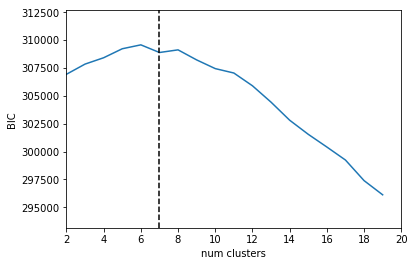

In [61]:
plt.plot(np.arange(2, 20), bics)
plt.plot(7.*np.ones(2), [np.min(bics)*0.99, np.max(bics)*1.01], linestyle = "--", c='black')
plt.xlim([2,20])
plt.ylim([np.min(bics)*0.99, np.max(bics)*1.01])
plt.xlabel("num clusters")
plt.ylabel("BIC")

sil = []
from sklearn.metrics import silhouette_score
for n in range(2, 20):
    m = KMeans(n_clusters=n, n_init=100)
    km.fit(tfidf_matrix)
    label = km.labels_
    sil_coeff = silhouette_score(tfidf_matrix, label, metric='euclidean')
    sil.append(sil_coeff)


plt.plot(np.arange(2, 20), sil)
plt.plot(7.*np.ones(2), [np.min(sil)*0.99, np.max(sil)*1.01], linestyle = "--", c='black')
plt.xlim([2,20])
plt.ylim([np.min(sil)*0.99, np.max(sil)*1.01])
plt.xlabel("num clusters")
plt.ylabel("sil")

In [176]:
from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

"\nbox = ax.get_position()\nax.set_position([box.x0, box.y0 + box.height * 0.1,\n                 box.width, box.height * 0.9])\n\nax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),\n          fancybox=True,  ncol = 1)\n"

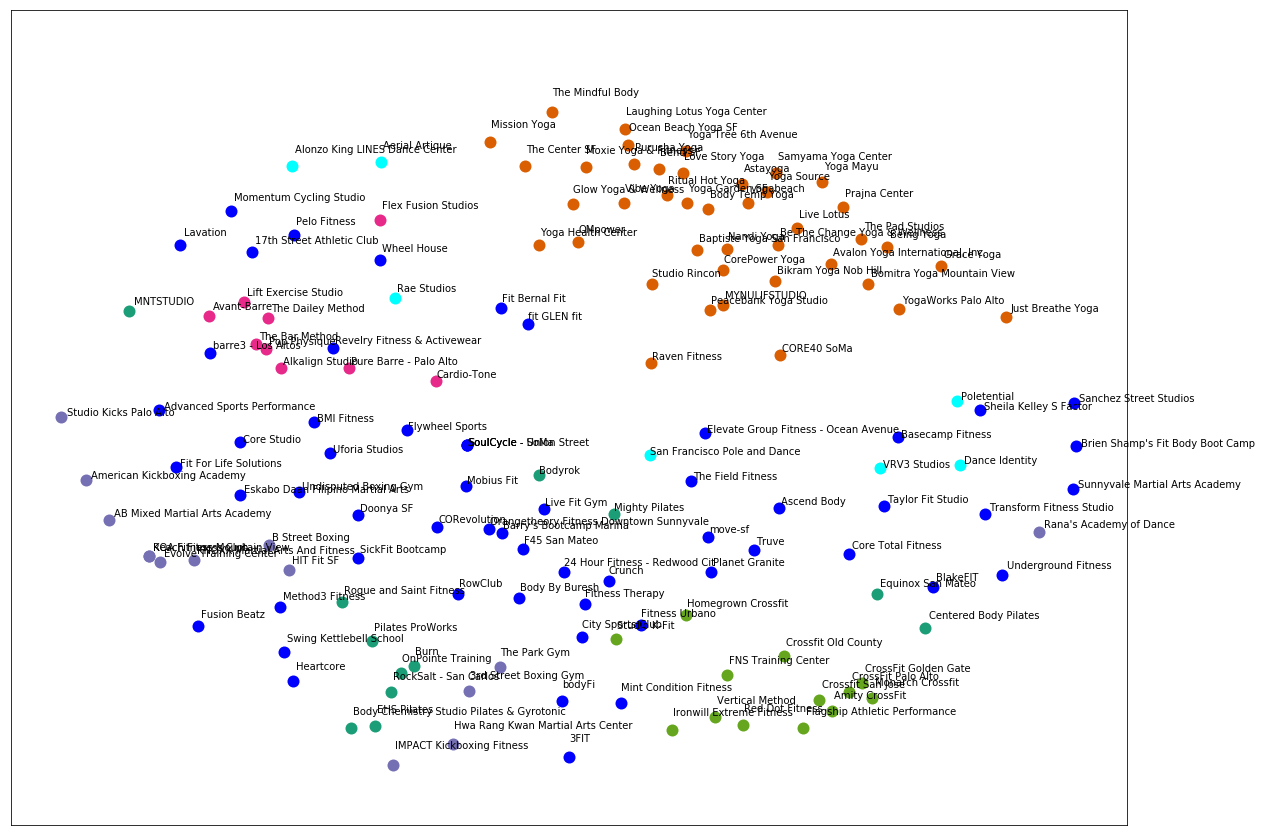

In [179]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=studioNames)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(20, 15)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    


#ax.set_xlim([-1,1] )
ax.set_ylim([-0.9,1])
#add label in x,y position with the label as the film title
for i in range(len(df)):
    xscalefactor = 1.01 if df.iloc[i]['x'] >0 else 0.99
    yscalefactor = 1.05 if df.iloc[i]['y'] >0 else 0.95
    ax.text(df.iloc[i]['x']*xscalefactor, df.iloc[i]['y']*yscalefactor, df.iloc[i]['title'], size=10)  

#ax.legend(numpoints=1)  #show legend with only 1 point
'''
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True,  ncol = 1)
'''    

#fig = plt.figure(figsize=(2, 1.25))
#patches = [
#    matplotlib.patches.Patch(color=color, label=label)
#    for label, color in zip(cluster_names, cluster_colors)]
#fig.legend(patches, labels, loc='center', frameon=False)
#plt.show()
#plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles, leaf_font_size=15);

#plt.ylabel("classes",fontsize=20)


plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout